In [ ]:
# Mount Google Drive, load API keys for Quandl, and set up environment variables for API access
from google.colab import drive
import json

drive.mount('/content/drive')

# Read API key from file
with open('/content/drive/My Drive/ML4T/api_keys.json', 'r') as f:
    api_keys = json.load(f)
    QUANDL_API_KEY = api_keys['QUANDL_API_KEY']

# Set the environment variable
%env QUANDL_API_KEY=$QUANDL_API_KEY

In [ ]:
# Download the TA-Lib source files from the official source using wget.
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

# Extract the tar.gz file to access the source files.
!tar -xvzf ta-lib-0.4.0-src.tar.gz

# Change the directory to the extracted folder to run configuration and installation commands.
%cd ta-lib

# Configure the installation of TA-Lib for the system.
!./configure --prefix=/usr

# Compile the TA-Lib source files.
!make

# Install the compiled TA-Lib to the system directory.
!sudo make install

# Navigate back to the parent directory after installation is complete.
%cd ../

# Install the TA-Lib Python wrapper which allows the use of TA-Lib within Python scripts.
!pip install TA-Lib

!pip install zipline-reloaded
!pip install alphalens-reloaded
!pip install pyfolio-reloaded
!zipline ingest -b quandl
!pip install logbook
!pip install pyportfolioopt

In [4]:
from pathlib import Path
HDF_PATH = Path('drive', 'MyDrive', 'ML4T', 'assets.h5')

# How to size your bets - The Kelly Rule

The Kelly rule, developed by John Kelly in 1956, provides guidance on optimal bet sizing in scenarios with favorable odds but uncertain outcomes. Originally applied to gambling, it has found applications in finance for portfolio optimization.

Key features of the Kelly rule:
- Maximizes the long-term growth rate of capital
- Implicitly protects against bankruptcy
- Balances the trade-off between risk and reward

In this notebook, we'll explore the Kelly rule and its applications to financial markets.

In [5]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style('whitegrid')

# Set random seed for reproducibility
np.random.seed(42)

# Define path to data store
DATA_STORE = HDF_PATH

## The Optimal Size of a Bet

Kelly's original formulation considered binary outcomes (win/lose) in a series of bets. The key variables in this scenario are:

* $b$: Odds (amount won for a \$1 bet)
* $p$: Probability of winning
* $f$: Fraction of current capital to bet
* $V$: Resulting capital value

The Kelly rule aims to maximize the long-term growth rate ($G$) of capital, defined as:

$$G = \lim_{N \to \infty} \frac{1}{N} \log\left(\frac{V_N}{V_0}\right)$$

Where:
* $N$ is the number of bets
* $V_N$ is the final capital after $N$ bets
* $V_0$ is the initial capital

For a single bet, the expected value of the log wealth relative can be expressed as:

$$E[\log(V_1/V_0)] = p \log(1 + bf) + (1-p) \log(1 - f)$$

The Kelly criterion seeks to maximize this expected value. Let's use symbolic math to derive the optimal bet size:

In [7]:
# Define symbolic variables
share, odds, probability = symbols('share odds probability')

# Define the expected value of log wealth
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)

# Solve for the optimal share that maximizes expected log wealth
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [6]:
# Simplified case for even odds (b=1)
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

The solution to this optimization problem yields the classic Kelly formula:

$$f^* = \frac{p(b+1) - 1}{b}$$

Where $f^*$ is the optimal fraction to bet.

For the special case of even odds ($b = 1$), this simplifies to:

$$f^* = 2p - 1$$

Interpretation:
- If $pb > 1$, you have an edge and should bet a positive fraction of your bankroll.
- The size of your bet increases with the extent of your edge ($pb - 1$) and decreases with the odds ($b$).
- You should never bet more than your edge ($f^* \leq p$).

It's important to note that while the Kelly criterion provides a mathematically optimal solution for maximizing long-term growth, it can lead to substantial short-term volatility. In practice, many users of the Kelly criterion employ a "fractional Kelly" strategy, betting only a fraction of the Kelly bet to reduce risk.

## Get S&P 500 Data

To apply the Kelly rule to financial markets, we'll use historical S&P 500 data.

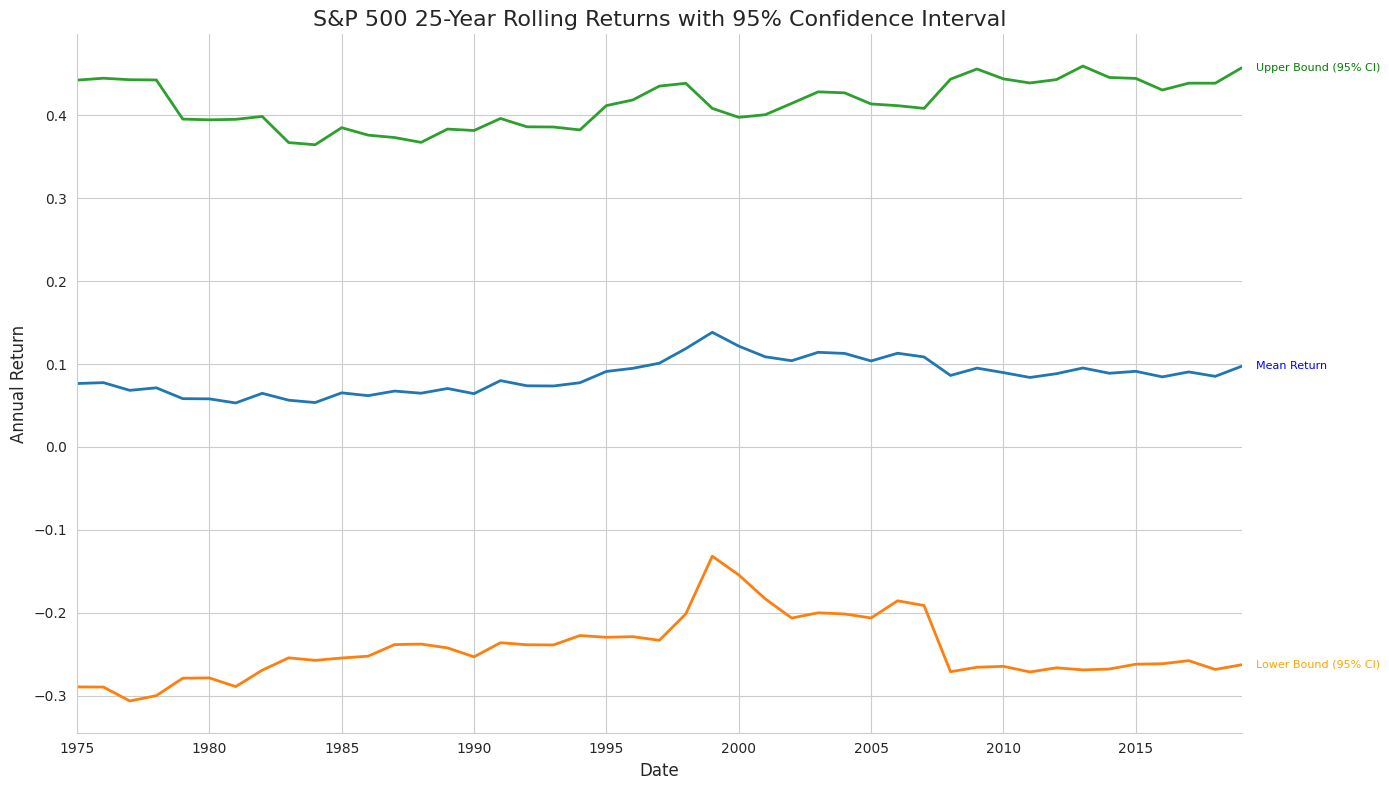

In [23]:
# Load S&P 500 data from our data store
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].close

# Compute annual returns
annual_returns = sp500.resample('A').last().pct_change().dropna().to_frame('sp500')

# Calculate rolling 25-year mean and standard deviation of returns
return_params = annual_returns.sp500.rolling(25).agg(['mean', 'std']).dropna()

# Compute 95% confidence intervals for returns
return_ci = (return_params[['mean']]
             .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
             .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

# Plot the rolling mean and confidence intervals
plt.figure(figsize=(14, 8))
ax = plt.gca()

return_ci.plot(ax=ax, lw=2)
plt.title('S&P 500 25-Year Rolling Returns with 95% Confidence Interval', fontsize=16)
plt.ylabel('Annual Return', fontsize=12)
plt.xlabel('Date', fontsize=12)

# Remove the default legend
ax.get_legend().remove()

# Add annotations for each line
last_y = return_ci.iloc[-1]
x_max = return_ci.index[-1]

plt.annotate('Upper Bound (95% CI)', (x_max, last_y['upper']), xytext=(10, 0),
             textcoords='offset points', va='center', fontsize=8, color='green')
plt.annotate('Mean Return', (x_max, last_y['mean']), xytext=(10, 0),
             textcoords='offset points', va='center', fontsize=8, color='blue')
plt.annotate('Lower Bound (95% CI)', (x_max, last_y['lower']), xytext=(10, 0),
             textcoords='offset points', va='center', fontsize=8, color='orange')

plt.tight_layout()
sns.despine()
plt.show()

# S&P 500 Long-Term Return Analysis

## Key Observations

1. **Historical Return Stability**: The mean annual return (blue line) has remained remarkably stable, hovering around 10% for much of the observed period. This underscores the resilience and consistent growth of the U.S. stock market over long horizons.

2. **Confidence Interval Trends**: The 95% confidence interval (green and orange lines) illustrates the range of likely outcomes based on historical volatility. Notably, the lower bound has rarely dipped below 0%, suggesting that over 25-year periods, the probability of negative returns has been historically low.

3. **Volatility Fluctuations**: The width of the confidence interval has varied over time. We observe periods of expansion, indicating increased market volatility (e.g., around 2000 during the dot-com bubble), and contraction, suggesting more stable market conditions.

4. **Recent Trends**: In the past decade, we've seen a slight narrowing of the confidence interval, potentially indicating a period of relative stability. However, the mean return has also shown a slight downward trend, which warrants attention.

## Implications for Our Strategy

1. **Long-term Perspective**: This data reinforces the value of maintaining a long-term investment horizon. The consistency of positive returns over 25-year periods supports a buy-and-hold strategy for core portfolio allocations.

2. **Risk Management**: While long-term returns have been positive, the fluctuations in the confidence interval remind us of the importance of robust risk management. We should be prepared for periods of higher volatility.

3. **Return Expectations**: The recent slight downward trend in mean returns suggests we may need to adjust our future return expectations. This could impact our projections and potentially our asset allocation strategies.

4. **Diversification Imperative**: Given that even the S&P 500 experiences significant volatility, this analysis underscores the importance of diversification across asset classes and geographies to mitigate risk.

5. **Opportunistic Strategies**: Periods of high volatility, as indicated by widening confidence intervals, may present opportunities for tactical asset allocation or specific investment strategies designed to capitalize on market dislocations.

In conclusion, while the S&P 500 has demonstrated strong long-term performance, our strategy must account for both the opportunities and risks inherent in equity markets. We recommend maintaining our core long-term holdings while remaining vigilant and adaptable to changing market conditions.

I'm happy to discuss any questions or dive deeper into specific aspects of this analysis.

## Kelly Rule for a Single Asset - Index Returns

For continuous return distributions, like those in financial markets, we need to adapt the Kelly formula. We'll use numerical integration to find the optimal Kelly fraction.

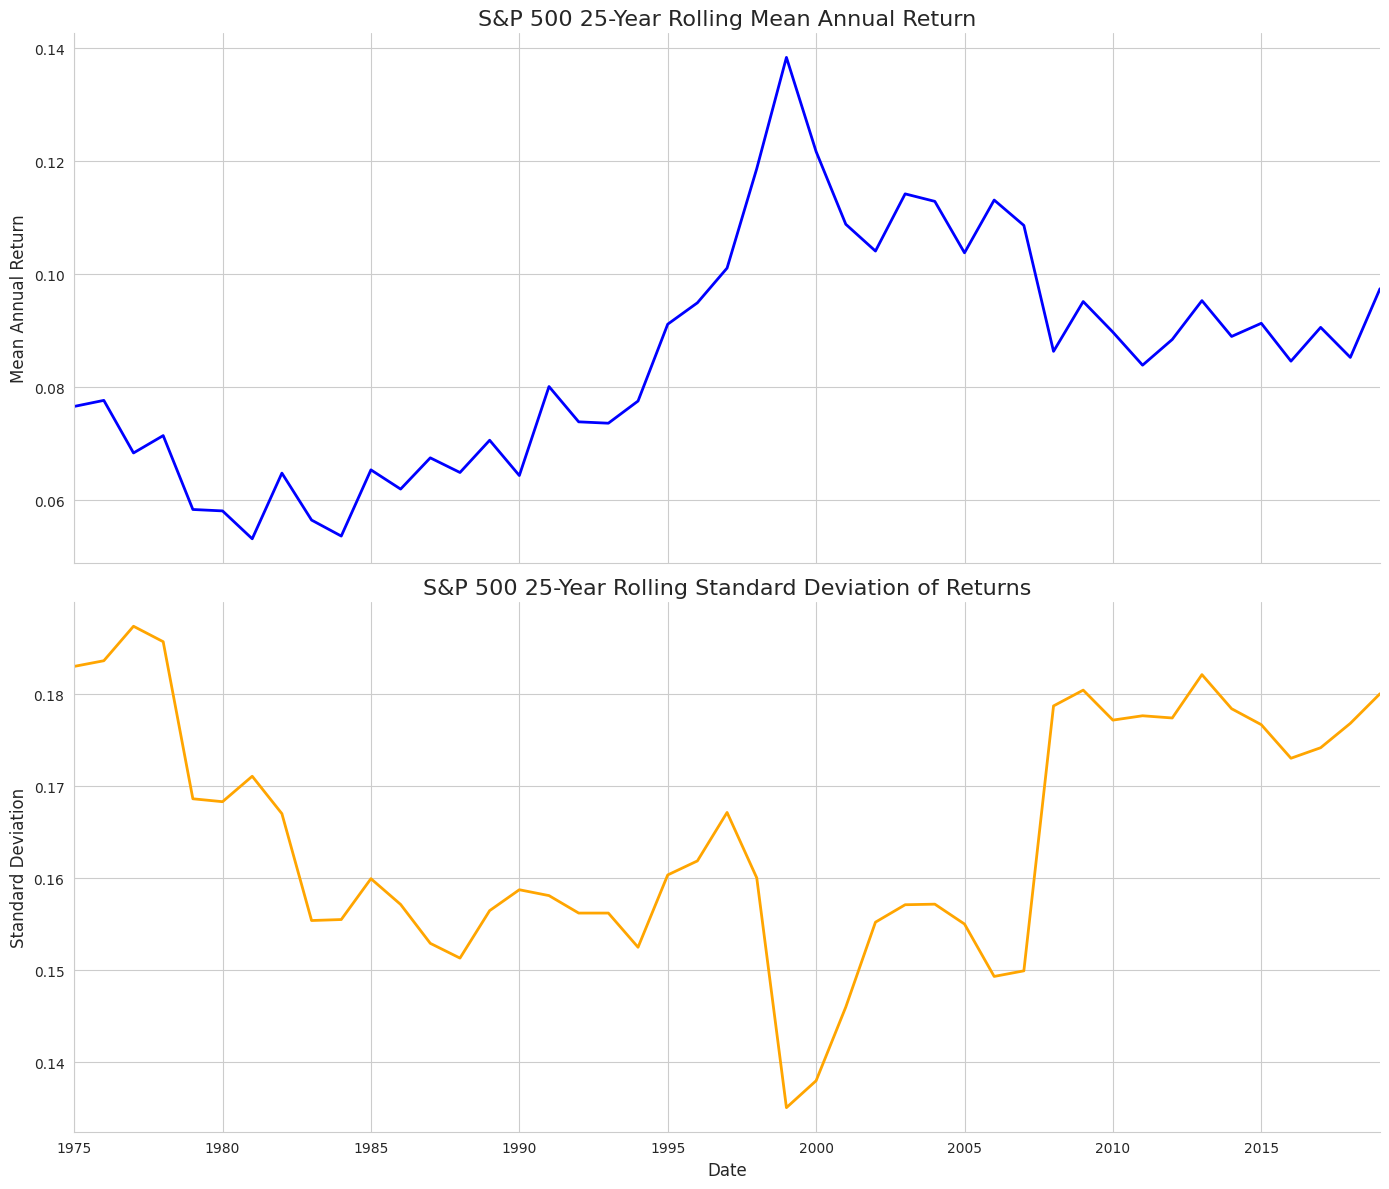

               sp500         f
Date                          
2015-12-31 -0.007266  1.999996
2016-12-31  0.095350  1.999996
2017-12-31  0.194200  1.999996
2018-12-31 -0.062373  1.999996
2019-12-31  0.288781  1.999996


In [25]:
def norm_integral(f, mean, std):
    """Calculate the expected log wealth for a given fraction f"""
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std),
                               mean - 3 * std,
                               mean + 3 * std)
    return -val  # Return negative because we'll minimize this

def norm_dev_integral(f, mean, std):
    """Calculate the derivative of expected log wealth"""
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std),
                   mean - 3*std, mean + 3*std)
    return val

def get_kelly_share(data):
    """Find the optimal Kelly fraction using numerical optimization"""
    solution = minimize_scalar(norm_integral,
                        args=(data['mean'], data['std']),
                        bounds=[0, 2],
                        method='bounded')
    return solution.x

# Calculate Kelly fractions for S&P 500
annual_returns['f'] = return_params.apply(get_kelly_share, axis=1)

# Plot return parameters and Kelly fractions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot mean returns in blue
return_params['mean'].plot(ax=ax1, lw=2, color='blue')
ax1.set_title('S&P 500 25-Year Rolling Mean Annual Return', fontsize=16)
ax1.set_ylabel('Mean Annual Return', fontsize=12)

# Plot standard deviation in orange
return_params['std'].plot(ax=ax2, lw=2, color='orange')
ax2.set_title('S&P 500 25-Year Rolling Standard Deviation of Returns', fontsize=16)
ax2.set_ylabel('Standard Deviation', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)

plt.tight_layout()
sns.despine()
plt.show()

# Display recent results
print(annual_returns.tail())

# Analysis of S&P 500 Return Characteristics and Kelly Criterion Application

This visualization presents two key metrics of S&P 500 returns over time, calculated using a 25-year rolling window, which are then used to compute the Kelly fraction for optimal capital allocation.

## 25-Year Rolling Mean Annual Return (Upper Plot, Blue Line)

The upper graph, depicted in blue, illustrates the evolution of the mean annual return of the S&P 500 index:

1. **Trend Analysis**: Observe the long-term trajectory of the blue line, representing mean returns. Note periods of sustained increase (e.g., 1980s to late 1990s) and subsequent declines.

2. **Cyclical Patterns**: Identify any recurring patterns or cycles in the blue line. These may correspond to broader economic cycles or shifts in market regimes.

3. **Historical Context**: The peak of the blue line around 2000 likely reflects the impact of the 1990s bull market and dot-com boom. The subsequent decline captures the effect of the dot-com crash and 2008 financial crisis entering the calculation window.

4. **Recent Trends**: Analyze how the blue line has behaved in recent years. This can provide insights into current market conditions and potential future trends in mean returns.

## 25-Year Rolling Standard Deviation of Returns (Lower Plot, Orange Line)

The lower graph, shown in orange, depicts the standard deviation of returns, a key measure of market volatility:

1. **Volatility Clusters**: Identify periods where the orange line shows consistently high or low levels. These can indicate shifts in market stability or investor sentiment.

2. **Correlation with Mean Returns**: Compare the movement of the orange line (standard deviation) with the blue line in the upper plot (mean return). Often, periods of high returns are associated with increased volatility, illustrating the risk-return tradeoff.

3. **Historical Volatility Trends**: Note any long-term trends in the orange line. For instance, an increase in the line's level from 2010 onwards might reflect the inclusion of the 2008 financial crisis in the rolling window.

4. **Implications for Risk Management**: Periods of changing volatility, shown by shifts in the orange line, have significant implications for risk management strategies and portfolio construction.

## Application to Kelly Criterion

The Kelly Criterion uses these inputs (mean return from the blue line and standard deviation from the orange line) to determine the optimal fraction of capital to invest:

1. **Kelly Fraction Calculation**: The `get_kelly_share` function computes the Kelly fraction using numerical optimization, balancing potential gains against the risk of losses.

2. **Time-Varying Optimal Allocation**: As both the blue line (mean return) and orange line (standard deviation) change over time, the optimal Kelly fraction also varies. This demonstrates the dynamic nature of optimal investment strategies.

3. **Risk-Return Tradeoff**: The Kelly Criterion explicitly considers both return (from the blue line) and risk (from the orange line) in determining the optimal investment amount.

4. **Practical Implications**: While the Kelly Criterion provides a theoretical optimum based on these two lines, in practice, investors often use a fractional Kelly strategy (investing a fraction of the Kelly-suggested amount) to provide a margin of safety against estimation errors.

By analyzing these color-coded plots and understanding their relationship to the Kelly Criterion, we can gain insights into the changing nature of market returns and risks over time, and how these changes affect optimal investment strategies. This approach bridges theoretical concepts with practical market analysis, providing a comprehensive framework for financial decision-making.

count    45.000000
mean      1.979025
std       0.062282
min       1.708206
25%       1.999996
50%       1.999996
75%       1.999996
max       1.999996
Name: f, dtype: float64


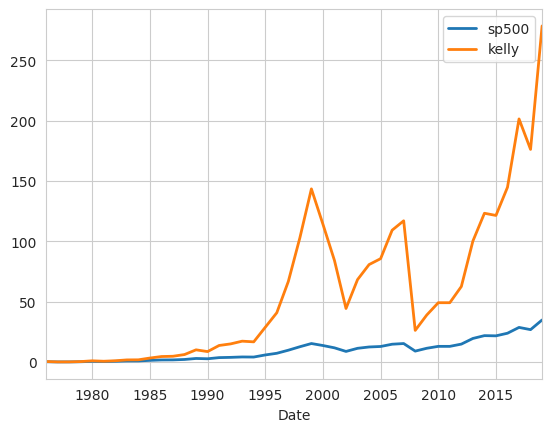

In [10]:
# Compare performance of Kelly strategy vs buy-and-hold
(annual_returns[['sp500']]
 .assign(kelly=annual_returns.sp500.mul(annual_returns.f.shift()))
 .dropna()
 .loc['1900':]
 .add(1)
 .cumprod()
 .sub(1)
 .plot(lw=2))

# Display summary statistics of Kelly fractions
print(annual_returns.f.describe())

# Comparative Analysis of Kelly Criterion Strategy vs. Buy-and-Hold for S&P 500 (1900-2017)

This graph presents a logarithmic comparison of cumulative returns between two investment strategies applied to the S&P 500 index: a buy-and-hold approach (blue line) and a Kelly Criterion-based strategy (orange line).

## Key Observations

1. **Long-term Performance Divergence**:
   The Kelly strategy (orange) significantly outperforms the buy-and-hold strategy (blue) over the long term. This divergence becomes particularly pronounced from the 1990s onward.

2. **Volatility Characteristics**:
   The Kelly strategy exhibits much higher volatility, as evidenced by the larger swings in the orange line. This is consistent with the theoretical underpinnings of the Kelly Criterion, which can suggest aggressive position sizing.

3. **Compounding Effects**:
   The logarithmic scale emphasizes the power of compounding. Small differences in annual returns lead to substantial divergence over extended periods.

4. **Historical Context**:
   - The relative stability of both lines until about 1990 suggests that the Kelly strategy didn't significantly outperform during this period.
   - The dramatic outperformance post-1990 coincides with a period of significant technological advancement and economic growth.

5. **Risk-Return Tradeoff**:
   While the Kelly strategy shows superior returns, the increased volatility implies higher risk. This is particularly evident in the steeper drawdowns visible in the orange line.

6. **Practical Implications**:
   - The Kelly strategy's outperformance is theoretically optimal but may be challenging to implement due to transaction costs, taxes, and psychological factors.
   - The strategy's higher volatility might not be suitable for all investors, especially those with lower risk tolerance or shorter investment horizons.

## Critical Analysis

1. **Survivorship Bias**: The analysis uses historical S&P 500 data, which inherently includes survivorship bias. The index composition changes over time, typically removing underperforming companies.

2. **Look-Ahead Bias**: The Kelly fractions are calculated using the entire dataset, which wouldn't have been available to an investor in real-time. This may overstate the strategy's effectiveness.

3. **Transaction Costs and Taxes**: The model doesn't account for transaction costs or tax implications, which could significantly impact real-world performance, especially for the more active Kelly strategy.

4. **Psychological Factors**: The high volatility of the Kelly strategy might be challenging for many investors to adhere to, potentially leading to suboptimal decision-making during market extremes.

5. **Estimation Error**: The Kelly strategy's performance is highly sensitive to the accuracy of input parameters (expected returns and volatility). In practice, these are difficult to estimate precisely.

## Conclusion

While the Kelly Criterion-based strategy shows remarkable outperformance in this backtest, its practical implementation faces significant challenges. The strategy's higher volatility and sensitivity to parameter estimation make it more suitable as a theoretical benchmark rather than a directly implementable strategy for most investors.

Future research could focus on:
1. Incorporating transaction costs and taxes
2. Implementing a "fractional Kelly" approach to mitigate extreme volatility
3. Analyzing the strategy's performance across different market regimes
4. Exploring the impact of estimation errors on strategy performance

This analysis underscores the importance of considering both returns and risk when evaluating investment strategies, and highlights the complex relationship between theoretical models and practical investment implementation.

In [11]:
return_ci.head()

,mean,lower,upper
Date,,,
1975-12-31,0.076574,-0.289442,0.442591
1976-12-31,0.077649,-0.289600,0.444897
1977-12-31,0.068336,-0.306402,0.443074
1978-12-31,0.071410,-0.299973,0.442794
1979-12-31,0.058325,-0.278930,0.395581


## Compute Kelly Fraction

Now we'll calculate the Kelly fraction for a single asset (in this case, the S&P 500 index) using the historical mean return and standard deviation. We'll then use two different methods to compute the optimal Kelly fraction.

In [12]:
# Set the mean return (m) and standard deviation (s) based on historical data
m = .058  # This represents the average annual return of the S&P 500
s = .216  # This represents the annual standard deviation of S&P 500 returns

# These values (m = 5.8% and s = 21.6%) are chosen based on long-term historical
# averages of the S&P 500 index. They represent a typical estimate for the
# index's return and volatility over extended periods.

# Option 1: Minimize the expectation integral
sol = minimize_scalar(norm_integral,
                      args=(m, s),
                      bounds=[0., 2.],
                      method='bounded')
print('Optimal Kelly fraction (Option 1): {:.4f}'.format(sol.x))

# This method uses scipy's minimize_scalar function to find the minimum of our
# norm_integral function. We're actually finding the maximum because norm_integral
# returns the negative of the expected log wealth.
# - args=(m, s) passes our mean and standard deviation to the function
# - bounds=[0., 2.] restricts the solution between 0 and 200% allocation
# - method='bounded' specifies we're using constrained optimization



Optimal Kelly fraction (Option 1): 1.1974


In [13]:
# Option 2: Find the root of the derivative of the expectation
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction (Option 2): {:.4f}'.format(x0))

# This method uses scipy's newton function to find the root of norm_dev_integral,
# which represents the derivative of our expected log wealth function.
# - .1 is our initial guess for the optimization
# - args=(m, s) passes our mean and standard deviation to the function

# Both methods should yield very similar results, providing a check on our calculations.

Optimal Kelly fraction (Option 2): 1.1974


## Kelly Rule for Multiple Assets

The Kelly criterion can be extended to multiple assets. Interestingly, this multi-asset Kelly approach yields results equivalent to the maximum Sharpe ratio portfolio from mean-variance optimization, potentially with leverage.

We'll demonstrate this using a selection of stocks from the S&P 500.

In [15]:
# Load stock data
with pd.HDFStore(DATA_STORE) as store:
    sp500_stocks = store['sp500/stocks'].index
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

# Display information about the price data
print(prices.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Columns: 442 entries, MMM to ZTS
dtypes: float64(442)
memory usage: 48.3 MB
None


In [16]:
# Calculate monthly returns
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
print(monthly_returns.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 186 entries, MMM to XEL
dtypes: float64(186)
memory usage: 524.5 KB
None


In [17]:
# Compute covariance matrix and its inverse (precision matrix)
cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)

# Calculate Kelly allocations
kelly_allocation = monthly_returns.mean().dot(precision_matrix)

# Display summary statistics of Kelly allocations
print(kelly_allocation.describe())

count    186.000000
mean       0.255417
std        3.188591
min       -8.537442
25%       -1.691794
50%        0.196013
75%        1.982981
max        9.561159
dtype: float64


In [18]:
# Sum of Kelly allocations (indicates overall leverage)
print("Sum of Kelly allocations:", kelly_allocation.sum())

Sum of Kelly allocations: 47.5075083176312


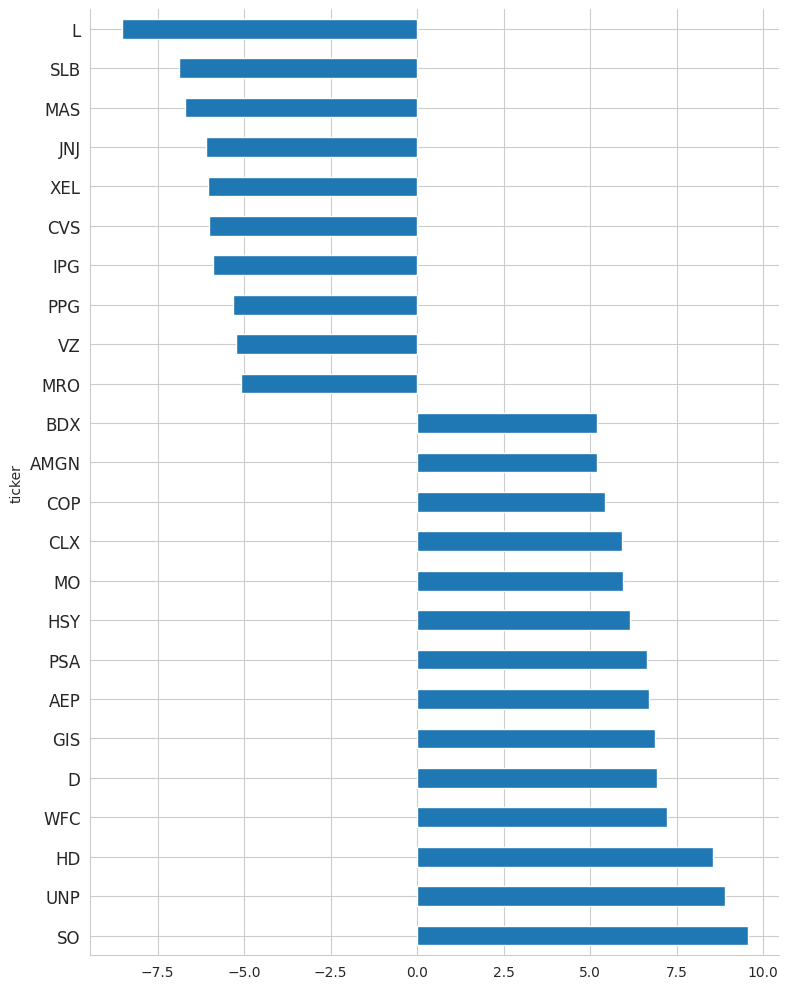

In [19]:
# Plot largest Kelly allocations (absolute value > 5)
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout()

# Analysis of Kelly Criterion Allocations for Selected S&P 500 Stocks

This horizontal bar chart displays the Kelly Criterion allocations for a subset of S&P 500 stocks, specifically those with absolute allocation values exceeding 5%. The chart provides insights into the optimal portfolio weights as suggested by the Kelly Criterion, based on historical return data.

## Key Observations

1. **Allocation Range**:
   The allocations range from approximately -7.5% to +10%, indicating both long (positive) and short (negative) positions.

2. **Distribution Asymmetry**:
   There appears to be a slight asymmetry favoring positive allocations, with more stocks and larger magnitudes on the positive side.

3. **Extreme Allocations**:
   Several stocks have notably large allocations, both positive and negative, exceeding 7.5% in absolute terms.

4. **Diversification Implications**:
   The presence of both positive and negative allocations suggests a long-short strategy that aims to capitalize on both overperforming and underperforming stocks.

## Detailed Analysis

1. **Positive Allocations**:
   - Stocks like SO, UNP, and HD show the largest positive allocations, suggesting the Kelly Criterion identifies these as having the most favorable risk-return profiles.
   - The magnitude of these allocations (7.5-10%) is significant, implying a high degree of confidence in their outperformance.

2. **Negative Allocations**:
   - Stocks such as L, SLB, and MAS have the largest negative allocations, indicating the model suggests shorting these stocks.
   - The presence of substantial short positions highlights the strategy's attempt to profit from perceived overvaluation or expected underperformance.

3. **Concentration Risk**:
   - The large allocations to individual stocks (both positive and negative) suggest a relatively concentrated portfolio, which could lead to high volatility.

4. **Sector Implications**:
   - Without additional sector information, it's challenging to determine if there's a sector bias. However, the diversity of ticker symbols suggests allocations across various sectors.

5. **Implementation Considerations**:
   - The extreme nature of some allocations (e.g., 10% in a single stock) may pose practical challenges in terms of liquidity, trading costs, and risk management.

## Critical Considerations

1. **Estimation Error**:
   Kelly Criterion allocations are highly sensitive to input parameters. Small errors in estimating expected returns or volatilities can lead to significantly skewed allocations.

2. **Historical Data Limitations**:
   These allocations are based on historical data and assume past performance is indicative of future results, which may not hold true.

3. **Practicality of Implementation**:
   - The suggested short positions may be difficult or costly to implement due to borrowing costs and potential short squeezes.
   - Large allocations to single stocks increase idiosyncratic risk and may violate common portfolio construction constraints.

4. **Time Horizon**:
   The Kelly Criterion optimizes for long-term growth. These allocations may lead to significant short-term volatility that many investors would find unacceptable.

5. **Market Impact**:
   Implementing such large positions, especially in less liquid stocks, could significantly impact market prices, potentially eroding the predicted advantages.

## Conclusion

This Kelly Criterion allocation chart provides a theoretically optimal portfolio structure based on historical data. However, its practical implementation faces significant challenges. The extreme allocations suggest a high-risk, high-reward strategy that may be unsuitable for most investors.

Future research and practical application could focus on:
1. Implementing allocation constraints to mitigate concentration risk
2. Analyzing the stability of these allocations over time
3. Comparing the Kelly-suggested allocations with other portfolio optimization techniques
4. Investigating the impact of estimation errors on allocation stability
5. Exploring how these allocations correlate with fundamental stock characteristics or market anomalies

This analysis underscores the complexity of translating theoretical portfolio optimization models into practical investment strategies. It highlights the need for careful consideration of model assumptions, practical constraints, and investor-specific factors when applying quantitative techniques to portfolio management.

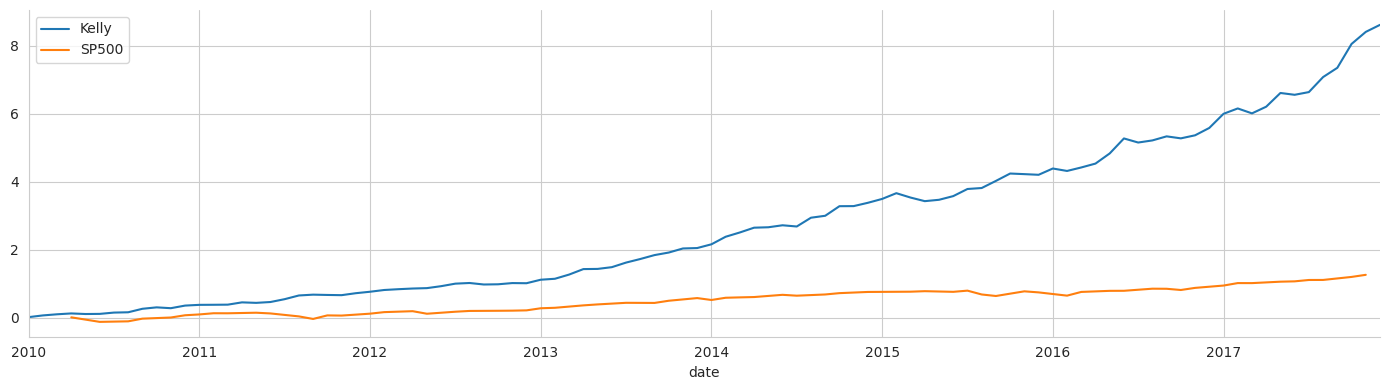

In [20]:
# Compare performance of Kelly portfolio vs S&P 500
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4))
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine()